# Домашнее задание №2. Multi-class SVM.

Нужно реализовать несколько алгоритмов SVM с помощью numpy/scipy библиотек. Каждую из реализаций сравнить с соответсвующей sklearn реализацией SVM алгоритма.

### Imports

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as pltcolors

from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import SGDClassifier
from sklearn.datasets import make_blobs, make_classification
from sklearn.metrics import accuracy_score

### Constants

In [5]:
RANDOM_STATE = 42

WINE_DATA_PATH = '../data/raw/wine.csv'

FEATURE_TARGET = 'Wine'

## Задание №1 (15 баллов)

Реализовать класс **LinearPrimalSVM** - метод решения **много-классового линейного метода опорных векторов в стандартной задаче  оптимизации с квадратичной регуляризацией**. Для обучения много-классового алгоритма воспользоваться схемой **one-vs-rest**.  Реализовать методы init, fit, predict c возможностью конфигурации параметра регуляризации. Остальные функции реализовать на ваше усмотрение.

Для оптимизации функции ошибки воспользоваться методом **стохастического градиентного спуска**.

In [6]:
class LinearPrimalSVM:

    class InnerClassifier:
        def __init__(self, regularization_type, learning_rate, tol, C, max_iter, batch_size, random_state):
            self.regularization_type = regularization_type
            self.learning_rate = learning_rate
            self.tol = tol
            self.C = C
            self.max_iter = max_iter
            self.batch_size = batch_size
            self.random_state = random_state

            self.w = None
            self.losses = None

        def hinge_loss(self, x_i, y_i):
            return max(0, 1 - y_i * np.dot(x_i, self.w))

        def soft_margin_loss(self, x_i, y_i):
            return self.hinge_loss(x_i, y_i) + self.C * np.dot(self.w, self.w)

        def __gradient(self, x_i, y_i):
            M_i = y_i * np.dot(self.w, x_i)

            if M_i >= 1:
                return - self.learning_rate * self.C * self.w / self.max_iter
            return self.learning_rate * (y_i * x_i - self.C * self.w / self.max_iter)

        def __gradient_descent(self, X_train, y_train):
            for _ in range(self.max_iter):
                loss = 0
                delta_w_sum = 0

                batch_idx = np.random.choice(X_train.shape[0], size=self.batch_size)
                X_batch, y_batch = X_train[batch_idx], y_train[batch_idx]

                for x_i, y_i in zip(X_batch, y_batch):
                    delta_w = self.__gradient(x_i, y_i)
                    delta_w_sum += delta_w

                    self.w += delta_w
                    loss += self.soft_margin_loss(x_i, y_i)

                if np.all(np.abs(delta_w_sum) <= self.tol):
                    break
                self.losses.append(loss)

        def fit(self, X_train, y_train):
            n, f = X_train.shape

            X_train = np.concatenate((X_train, np.ones((n, 1))), axis=1)
            X_train[:, -1] = 1
            self.w = np.zeros((f + 1))
            self.losses = []

            self.__gradient_descent(X_train, y_train)

        def predict_scores(self, X):
            X_pred = np.concatenate((X, np.ones((X.shape[0], 1))), axis=1)

            return np.array(np.dot(X_pred, self.w))

    def __init__(self,
                 regularization_type='l2',
                 learning_rate=0.1,
                 tol=1e-4,
                 C=0.01,
                 max_iter=1000,
                 batch_size=16,
                 random_state=None,
                ):
        self.regularization_type = regularization_type
        self.learning_rate = learning_rate
        self.tol = tol
        self.C = C
        self.max_iter = max_iter
        self.batch_size = batch_size,
        self.random_state = random_state

        self.labels = []
        self.clfs = []

    def fit(self, X, y):
        X_train = np.array(X)
        y_train = np.array(y)

        self.labels = np.unique(y)
        for i, label in enumerate(self.labels):
            y_train = np.where(y == label, 1, -1)
            self.clfs.append(self.InnerClassifier(
                self.regularization_type,
                self.learning_rate,
                self.tol,
                self.C,
                self.max_iter,
                self.batch_size,
                self.random_state,
            ))
            self.clfs[i].fit(X_train, y_train)

    def predict(self, X):
        scores = pd.DataFrame()

        for i, label in enumerate(self.labels):
            scores[label] = self.clfs[i].predict_scores(X)
        return self.labels[scores.idxmax(axis=1) - 1]

    def get_params(self, deep=False):
        return {
            'regularization_type': self.regularization_type,
            'learning_rate': self.learning_rate,
            'tol': self.tol,
            'C': self.C,
            'max_iter': self.max_iter,
            'random_state': self.random_state,
        }

Оцените ваш алгоритм на тестовом сплите многоклассовом датасете классификации по выбранной метрике качества. Датасеты для классификации можно взять например [**отсюда**](https://archive.ics.uci.edu/ml/datasets.php?format=&task=cla&att=&area=&numAtt=&numIns=&type=&sort=nameUp&view=table) или сгенерировать самому. Сравните ваш алгоритм с sklearn имплементацией со следующими парарметрами:

[*_sklearn.linear_model.SGDClassifier(loss='hinge', penalty='l2', fit_intercept=True)_*](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)

Остальные параметры алгоритма на ваше усмотрение.

Отличие в качестве не должно составлять более **1-2%** в пользу sklearn имплементации. Ваш алгоритм может работать лучше.

### Read

In [7]:
def read_data(path):
    return pd.read_csv(path)

In [8]:
# Костыль для Coolab

!gdown --folder https://drive.google.com/drive/folders/1WUkbhzBwOzRvOkFvTvV7q_qG7poTejCU?usp=sharing
WINE_DATA_PATH = '/content/data/raw/wine.csv'

Retrieving folder list
Retrieving folder 1J3rqJ5A70E77BHd2Y1kByyhj5XNb_ReD final
Processing file 1zG3PVao2LnJ4n2_JOviKK1OZIJuJ8hn_ .gitkeep
Retrieving folder 1RRTt_aNxBHEBpG--_Uf5b6isZUTsojzJ raw
Processing file 19BsqYgIUuxzwVsR22qmbTR7l8mDS2zWc wine.csv
Retrieving folder list completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1zG3PVao2LnJ4n2_JOviKK1OZIJuJ8hn_
To: /content/data/final/.gitkeep
0.00B [00:00, ?B/s]
Downloading...
From: https://drive.google.com/uc?id=19BsqYgIUuxzwVsR22qmbTR7l8mDS2zWc
To: /content/data/raw/wine.csv
100% 10.9k/10.9k [00:00<00:00, 31.9MB/s]
Download completed


In [9]:
df = read_data(WINE_DATA_PATH)
df.head()

,Wine,Alcohol,Malic.acid,Ash,Acl,Mg,Phenols,Flavanoids,Nonflavanoid.phenols,Proanth,Color.int,Hue,OD,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Wine                  178 non-null    int64  
 1   Alcohol               178 non-null    float64
 2   Malic.acid            178 non-null    float64
 3   Ash                   178 non-null    float64
 4   Acl                   178 non-null    float64
 5   Mg                    178 non-null    int64  
 6   Phenols               178 non-null    float64
 7   Flavanoids            178 non-null    float64
 8   Nonflavanoid.phenols  178 non-null    float64
 9   Proanth               178 non-null    float64
 10  Color.int             178 non-null    float64
 11  Hue                   178 non-null    float64
 12  OD                    178 non-null    float64
 13  Proline               178 non-null    int64  
dtypes: float64(11), int64(3)
memory usage: 19.6 KB


### Feature Utility Scores and Drop Uninformative

In [11]:
def make_mi_scores(X, y, random_state=0):
    X = X.copy()
    for feature in X.select_dtypes(['object', 'category', 'datetime64[ns]']):
        X[feature], _ = X[feature].factorize()

    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=random_state)
    mi_scores = pd.Series(mi_scores, name='MI Scores', index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [12]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title('Mutual Information Scores')

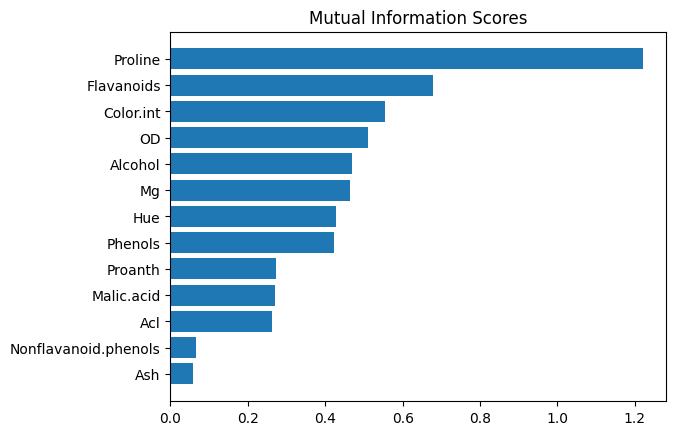

In [13]:
X = df.copy()
y = X.pop(FEATURE_TARGET)

mi_scores = make_mi_scores(X, y, random_state=RANDOM_STATE)
plot_mi_scores(mi_scores)

### Preprocessing Pipeline

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(142, 13) (36, 13) (142,) (36,)


In [15]:
def get_preprocessor(df, random_state=None):
    features_num = list(df.select_dtypes(('int64', 'float64')).columns)

    num_transformer = Pipeline([
        ('scaler', StandardScaler()),
        ('transformer', QuantileTransformer(n_quantiles=10, random_state=random_state)),
    ])

    preprocessor = ColumnTransformer([
        ('num', num_transformer, features_num),
    ])
    return preprocessor

In [16]:
preprocessor_train = get_preprocessor(X_train, random_state=RANDOM_STATE)
preprocessor_test = get_preprocessor(X_test, random_state=RANDOM_STATE)

In [17]:
X_train = pd.DataFrame(preprocessor_train.fit_transform(X_train))
X_train.columns = preprocessor_train.get_feature_names_out()
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142 entries, 0 to 141
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   num__Alcohol               142 non-null    float64
 1   num__Malic.acid            142 non-null    float64
 2   num__Ash                   142 non-null    float64
 3   num__Acl                   142 non-null    float64
 4   num__Mg                    142 non-null    float64
 5   num__Phenols               142 non-null    float64
 6   num__Flavanoids            142 non-null    float64
 7   num__Nonflavanoid.phenols  142 non-null    float64
 8   num__Proanth               142 non-null    float64
 9   num__Color.int             142 non-null    float64
 10  num__Hue                   142 non-null    float64
 11  num__OD                    142 non-null    float64
 12  num__Proline               142 non-null    float64
dtypes: float64(13)
memory usage: 14.5 KB


In [18]:
X_test = pd.DataFrame(preprocessor_test.fit_transform(X_test))
X_test.columns = preprocessor_test.get_feature_names_out()
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   num__Alcohol               36 non-null     float64
 1   num__Malic.acid            36 non-null     float64
 2   num__Ash                   36 non-null     float64
 3   num__Acl                   36 non-null     float64
 4   num__Mg                    36 non-null     float64
 5   num__Phenols               36 non-null     float64
 6   num__Flavanoids            36 non-null     float64
 7   num__Nonflavanoid.phenols  36 non-null     float64
 8   num__Proanth               36 non-null     float64
 9   num__Color.int             36 non-null     float64
 10  num__Hue                   36 non-null     float64
 11  num__OD                    36 non-null     float64
 12  num__Proline               36 non-null     float64
dtypes: float64(13)
memory usage: 3.8 KB


### Training and Comparison

In [19]:
my_linear_primal_svm = LinearPrimalSVM(regularization_type='l2', random_state=RANDOM_STATE)
sklearn_linear_primal_svm = SGDClassifier(loss='hinge', penalty='l2', fit_intercept=True, random_state=RANDOM_STATE)

my_clf_penalty_none_cv = cross_val_score(my_linear_primal_svm, X_train, y_train, cv=5, scoring='accuracy')
sklearn_clf_penalty_none_cv = cross_val_score(sklearn_linear_primal_svm, X_train, y_train, cv=5, scoring='accuracy')

print(f'Cross-val accuracy of my model: {my_clf_penalty_none_cv.mean():.4f}')
print(f'Cross-val accuracy of sklearn model: {sklearn_clf_penalty_none_cv.mean():.4f}')

Cross-val accuracy of my model: 0.9793
Cross-val accuracy of sklearn model: 0.9655


In [20]:
my_linear_primal_svm = LinearPrimalSVM(regularization_type='l2', random_state=RANDOM_STATE)
my_linear_primal_svm.fit(X_train, y_train)

print(f'Test sample accuracy: {accuracy_score(y_test, my_linear_primal_svm.predict(X_test)):.4f}')

Test sample accuracy: 1.0000


### Задание № 2 (10 баллов)

Визуализируйте построенные разделяющие прямые на вашем мультиклассовом датасете. Для визуализации можно пользоваться любыми библиотеками визуализации. В конце ноутбука приведены вспомогательные функции для визуализации.

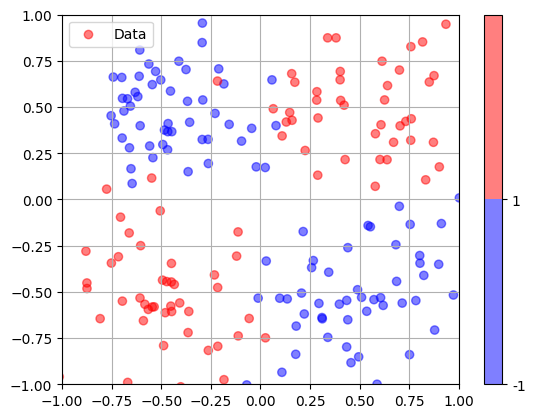

In [21]:
def plot_line(ax, x_range, w, x0, label, color='grey', linestyle='-', alpha=1.):
    """График разделяющей прямой с помощью вектора весов w и смещения x0"""
    if type(x0) == int or type(x0) == float or type(x0) == np.float64:
        x0 = [0, -x0 / w[1]]
    yy = -(w[0] / w[1]) * (x_range - x0[0]) + x0[1]
    ax.plot(x_range, yy, color=color, label=label, linestyle=linestyle)


def plot_svm(X, y, support=None, w=None, intercept=0., label='Data', separatorLabel='Separator',
            ax=None, bound=[[-1., 1.], [-1., 1.]]):
    """График SVM оптимальной разделяющей прямой c отображением опорных векторов support
    вектора весов w и смещения intercept"""
    if ax is None:
        fig, ax = plt.subplots(1)

    im = ax.scatter(X[:,0], X[:,1], c=y, cmap=cmap, alpha=0.5, label=label)
    if support is not None:
        ax.scatter(support[:,0], support[:,1], label='Support', s=80, facecolors='none',
                   edgecolors='y', color='y')
        print("Количество опорных векторов = %d" % (len(support)))
    if w is not None:
        xx = np.array(bound[0])
        plot_line(ax, xx, w, intercept, separatorLabel)
        # Plot margin
        if support is not None:
            signed_dist = np.matmul(support, w)
            margin = np.max(signed_dist) - np.min(signed_dist) * np.sqrt(np.dot(w, w))
            support_max_neg = support[np.argmin(signed_dist)]
            plot_line(ax, xx, w, support_max_neg, 'Margin -', linestyle='-.', alpha=0.8)
            support_max_pos = support[np.argmax(signed_dist)]
            plot_line(ax, xx, w, support_max_pos, 'Margin +', linestyle='--', alpha=0.8)
            ax.set_title('Margin = %.3f' % (margin))
    ax.legend(loc='upper left')
    ax.grid()
    ax.set_xlim(bound[0])
    ax.set_ylim(bound[1])
    cb = plt.colorbar(im, ax=ax)
    loc = np.arange(-1,1,1)
    cb.set_ticks(loc)
    cb.set_ticklabels(['-1','1'])


def generate_batch_xor(n, mu=0.5, sigma=0.5):
    """ гауссианы в форме XOR операции"""
    X = np.random.normal(mu, sigma, (n, 2))
    yB0 = np.random.uniform(0, 1, n) > 0.5
    yB1 = np.random.uniform(0, 1, n) > 0.5
    # y is in {-1, 1}
    y0 = 2. * yB0 - 1
    y1 = 2. * yB1 - 1
    X[:,0] *= y0
    X[:,1] *= y1
    X -= X.mean(axis=0)
    return X, y0*y1


colors = ['blue','red',]
cmap = pltcolors.ListedColormap(colors)
nFeatures = 2
N = 100
xTrain3, yTrain3 = generate_batch_xor(2*N, sigma=0.25)
plot_svm(xTrain3, yTrain3)
xTest3, yTest3 = generate_batch_xor(2*N, sigma=0.25)

In [22]:
def plot_multiclass_svm(model, X, y, support=None, ax=None, bound=[[-1., 1.], [-1., 1.]], cmap=pltcolors.ListedColormap(['red', 'blue'])):
    if ax is None:
        fig, ax = plt.subplots(1)

    im = ax.scatter(X[:,0], X[:,1], c=y, cmap=cmap, alpha=0.5)
    if support is not None:
        ax.scatter(support[:,0], support[:,1], label='Support', s=80, facecolors='none',
                   edgecolors='y', color='y')
        print("Количество опорных векторов = %d" % (len(support)))

    multi_w = [clf.w for clf in model.clfs]

    for i in range(len(multi_w)):
        w = multi_w[i][:-1]
        w0 = multi_w[i][-1]

        label = model.labels[i]
        color = cmap.colors[i]

        xx = np.array(bound[0])
        plot_line(ax, xx, w, w0, label=label, color=color)

        if support is not None:
            signed_dist = np.matmul(support, w)
            margin = np.max(signed_dist) - np.min(signed_dist) * np.sqrt(np.dot(w, w))
            support_max_neg = support[np.argmin(signed_dist)]
            plot_line(ax, xx, w, support_max_neg, 'Margin -', linestyle='-.', alpha=0.8)
            support_max_pos = support[np.argmax(signed_dist)]
            plot_line(ax, xx, w, support_max_pos, 'Margin +', linestyle='--', alpha=0.8)
            ax.set_title('Margin = %.3f' % (margin))

    ax.legend(loc='upper left')
    ax.grid()
    ax.set_xlim(bound[0])
    ax.set_ylim(bound[1])
    cb = plt.colorbar(im, ax=ax)
    loc = np.arange(-1,1,1)

In [23]:
X_blob, y_blob = make_blobs(n_samples=500, n_features=2, centers=3)

preprocessor_blob = get_preprocessor(pd.DataFrame(X_blob), random_state=RANDOM_STATE)
X_blob = pd.DataFrame(preprocessor_blob.fit_transform(X_blob))
X_blob.columns = preprocessor_blob.get_feature_names_out()
X_blob.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   num__x0  500 non-null    float64
 1   num__x1  500 non-null    float64
dtypes: float64(2)
memory usage: 7.9 KB


In [24]:
my_linear_primal_svm_for_2d = LinearPrimalSVM(regularization_type='l2', random_state=RANDOM_STATE)
my_linear_primal_svm_for_2d.fit(X_blob, y_blob)

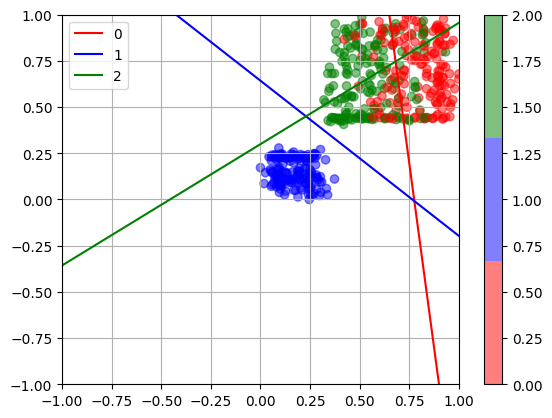

In [25]:
plot_multiclass_svm(my_linear_primal_svm_for_2d, X_blob.values, y_blob, cmap=pltcolors.ListedColormap(['red', 'blue', 'green']))

Постройте график зависимости качества вашего алгоритма от параметра регуляризации на тестовом сплите.

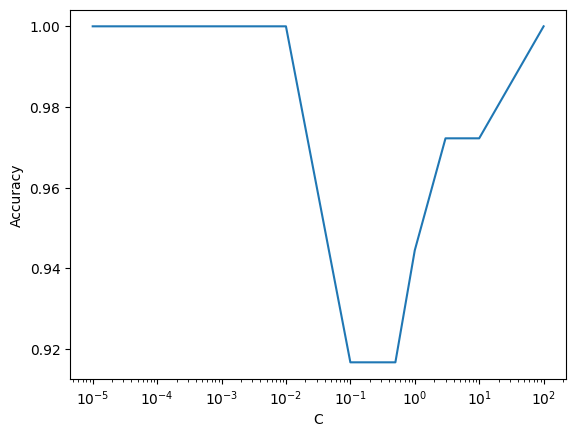

In [26]:
C_params = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.5, 1.0, 3.0, 10.0, 100.0]
accuracy = []

for C in C_params:
    svm = LinearPrimalSVM(regularization_type='l2', C=C)
    svm.fit(X_train, y_train)
    accuracy.append(np.mean(svm.predict(X_test) == y_test))

plt.xlabel('C')
plt.ylabel('Accuracy')
plt.xscale('log')

plt.plot(C_params, accuracy)
plt.show()

### Задание №3 (10 баллов)

Реализовать **NonlinearDualSVM** - метод решения **много-классового нелинейного метода опорных векторов двойственной задаче  оптимизации с квадратичной регуляризацией с поддежкой любого нелинейного ядра**. Алгоритм решения SVM через двойственную задачу можно взять из ноутбука, который мы рассматривали в классе - вам нужно поддержать многоклассовое решение задачи и поддержку ядра для решений в нелинейном случае.

Для обучения много-классового алгоритма воспользоваться схемой **one-vs-one**. В качестве нелинейного ядра можно взять любое нелинейное [отсюда](https://scikit-learn.org/stable/modules/svm.html#svm-kernels).

**Подсказка**

Получить получить ядерную матрицу Грамма можно так:

```python
# X shape is (N, dim)
# y_hat shape is (N, 1)

def kernel(x1, x2):
    return np.dot(x1, x2)

kernalized_X = np.apply_along_axis(lambda x1 : np.apply_along_axis(lambda x2: kernel(x1, x2), 1, X), 1, X)  
gram_matrix_Xy = kernalized_X * np.matmul(y_hat, y_hat.T)
```

In [ ]:
class NonlinearDualSVM(LinearPrimalSVM):
    def __init__(self,
                 regularization_type='l2',
                 learning_rate=0.1,
                 tol=1e-4,
                 C=0.01,
                 max_iter=1000,
                 batch_size=16,
                 random_state=None,
                 kernel='poly',
                 ):
      super(NonlinearDualSVM, self).__init__(learning_rate, tol, C, max_iter, batch_size, random_state)

    def kernel_poly(x1, x2):
      return np.dot(x1, x2)**2

    def fit():
        """функция обучения модели"""
        # CODE HERE
        pass

    def predict():
        """функция предсказания"""
        # CODE HERE
        pass

Оцените ваш алгоритм на тестовом сплите многоклассовом датасете классификации по выбранной метрике качества. Датасеты для классификации можно взять например [**отсюда**](https://archive.ics.uci.edu/ml/datasets.php?format=&task=cla&att=&area=&numAtt=&numIns=&type=&sort=nameUp&view=table) или сгенерировать самому. Сравните ваш алгоритм с sklearn имплементацией со следующими параметрами:

[*_class sklearn.svm.SVC(kernel='poly/rbf/sigmoid')_*](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC)

Остальные параметры алгоритма на ваше усмотрение либо при необходимости для выбранного ядра.

Ваш алгоритмом должен быть не хуже sklearn имплементации алгоритма (допустима разница **5%** в пользу sklearn). Ваш алгоритм может работать лучше.

#### Вспомогательные функции визуализации

Для удобства визуализации используйте эти функции.